# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [2]:
!pip install -U sagemaker

import sagemaker
import boto3

print(sagemaker.__version__)

2.132.0


In [3]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
!pip install kaggle
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [4]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /root/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
import json
kaggle_username = "danielthemunn"
kaggle_key = "44bd63a047be47a92ae48850e0e8487b"

# Save API token the kaggle.json file
with open("/root/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [6]:
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [7]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv")
train['datetime'] = pd.to_datetime(train['datetime'], format='%Y-%m-%d')
print(train.dtypes)
train.head()

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.count()
print(train.min(), train.max(), train.std(), train.var())

datetime      2011-01-01 00:00:00
season                          1
holiday                         0
workingday                      0
weather                         1
temp                         0.82
atemp                        0.76
humidity                        0
windspeed                     0.0
casual                          0
registered                      0
count                           1
dtype: object datetime      2012-12-19 23:00:00
season                          4
holiday                         1
workingday                      1
weather                         4
temp                         41.0
atemp                      45.455
humidity                      100
windspeed                 56.9969
casual                        367
registered                    886
count                         977
dtype: object datetime      210 days 12:08:09.411512940
season                           1.116174
holiday                          0.166599
workingday                    

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv('test.csv')
test['datetime'] = pd.to_datetime(test['datetime'], format='%Y-%m-%d')
print(test.dtypes)
test.head()

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
dtype: object


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission = pd.read_csv('sampleSubmission.csv')
submission['datetime'] = pd.to_datetime(submission['datetime'], format='%Y-%m-%d')
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [12]:
# Specify the feature types for each column, ignoring the columns you don't want to use

train = train.drop(columns=['casual', 'registered']) 

predictor = TabularPredictor(label='count', eval_metric='root_mean_squared_error', path='ag_models')
predictor.fit(train, presets='best_quality', time_limit=600)

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "ag_models/"
AutoGluon Version:  0.6.2
Python Version:     3.7.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Fri Dec 9 09:57:03 UTC 2022
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:     

### Review AutoGluon's training run with ranking of models that did the best.

In [13]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -53.105747      14.964256  548.658585                0.000906           0.384519            3       True         14
1   RandomForestMSE_BAG_L2  -53.424269      10.779898  408.428175                0.880120          27.000209            2       True         12
2          LightGBM_BAG_L2  -55.092932      10.107089  404.574509                0.207310          23.146543            2       True         11
3          CatBoost_BAG_L2  -55.713739       9.953321  443.382373                0.053543          61.954406            2       True         13
4        LightGBMXT_BAG_L2  -60.158940      13.822376  436.172908                3.922598          54.744941            2       True         10
5    KNeighborsDist_BAG_L1  -84.125061       0.104023    0.031008         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -116.54

### Create predictions from test dataset

In [14]:
predictions = predictor.predict(test)
predictions.head()

0    23.654850
1    42.605476
2    45.843338
3    49.451546
4    51.992085
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [15]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      101.010719
std        90.216118
min         3.258786
25%        20.136616
50%        64.165718
75%       167.551041
max       365.600830
Name: count, dtype: float64

In [16]:
# How many negative values do we have?
predictions[predictions <= 0].count()

0

In [17]:
# Set them to zero
predictions[predictions <= 0] = 0

### Set predictions to submission dataframe, save, and submit

In [18]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [19]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 330kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [20]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission.csv               2023-02-17 22:50:51  first raw submission               complete  1.79741      1.79741       
submission_new_hpo.csv       2023-02-13 20:26:45  new features with hyperparameters  complete  0.48580      0.48580       
submission_new_features.csv  2023-02-13 16:46:11  new features                       complete  0.69677      0.69677       
submission_new_features.csv  2023-02-13 16:25:51  new features                       complete  0.69154      0.69154       


#### Initial score of 1.78921

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

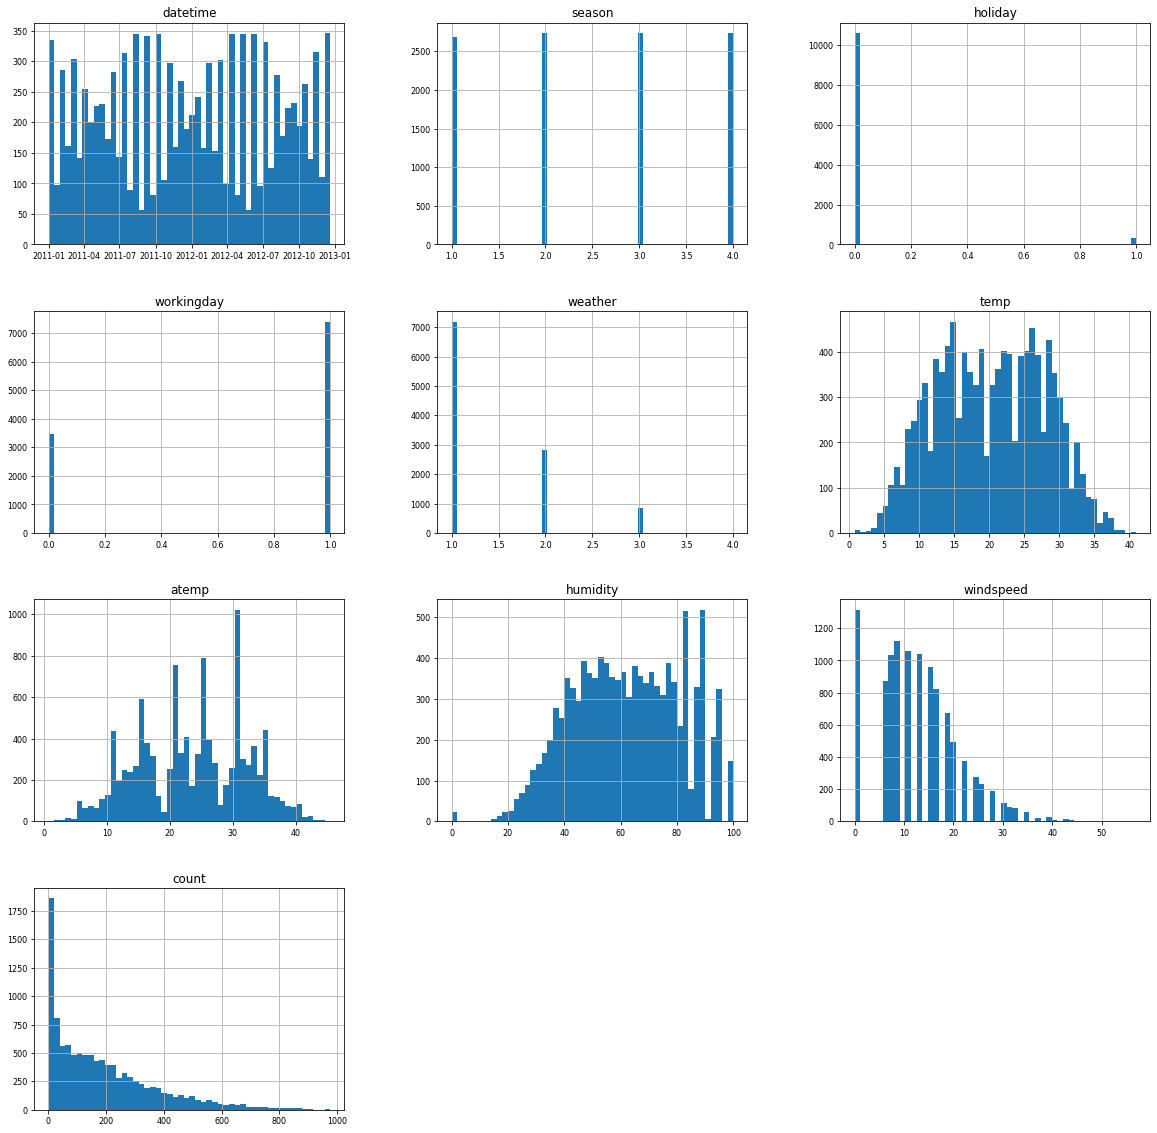

In [21]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
# train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [23]:
# create a new feature
train['dayofweek'] = train['datetime'].dt.dayofweek
train['hour'] = train['datetime'].dt.hour

test['dayofweek'] = test['datetime'].dt.dayofweek
test['hour'] = test['datetime'].dt.hour

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [ ]:
# Make category types for these so models know they are not just numbers
train["season"] = train["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["season"] = test["season"].astype("category")
test["weather"] = test["weather"].astype("category")

In [24]:
# View are new feature
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,dayofweek,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,5,4


In [25]:
# Check test has the same properties
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,dayofweek,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,3,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,3,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,4


array([[<AxesSubplot:title={'center':'datetime'}>,
        <AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>],
       [<AxesSubplot:title={'center':'workingday'}>,
        <AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>],
       [<AxesSubplot:title={'center':'atemp'}>,
        <AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>,
        <AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'hour'}>]], dtype=object)

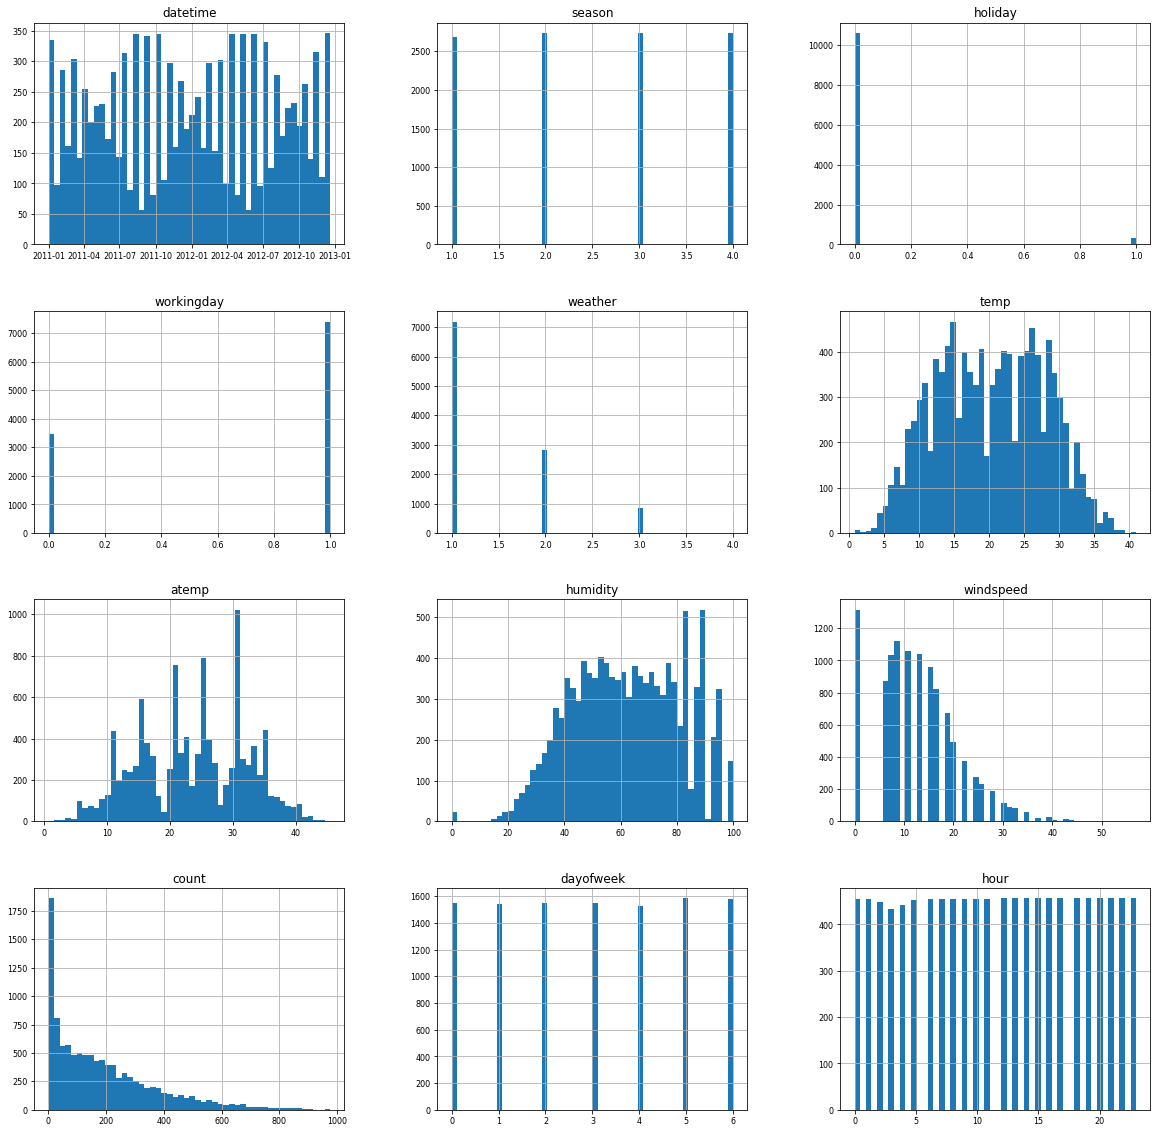

In [26]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)

## Step 5: Rerun the model with the same settings as before, just with more features

In [ ]:
predictor_new_features = TabularPredictor(label='count', eval_metric='root_mean_squared_error', path='ag_models')
predictor_new_features.fit(train, presets='best_quality', time_limit=600)

In [ ]:
predictor_new_features.fit_summary()

In [29]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    16.481604
1    11.962122
2    11.486063
3    10.040858
4     8.693262
Name: count, dtype: float32

In [30]:
# Remember to set all negative values to zero
predictions_new_features[predictions_new_features < 0] = 0

In [31]:
submission_new_features = pd.read_csv('sampleSubmission.csv')
submission_new_features['datetime'] = pd.to_datetime(submission_new_features['datetime'], format='%Y-%m-%d')
submission_new_features.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [32]:
# Same submitting predictions
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)
print('Saved')

Saved


In [33]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 476kB/s]
Successfully submitted to Bike Sharing Demand

In [34]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_features.csv  2023-02-17 23:02:39  new features                       complete  0.68883      0.68883       
submission.csv               2023-02-17 22:50:51  first raw submission               complete  1.79741      1.79741       
submission_new_hpo.csv       2023-02-13 20:26:45  new features with hyperparameters  complete  0.48580      0.48580       
submission_new_features.csv  2023-02-13 16:46:11  new features                       complete  0.69677      0.69677       


#### New Score of `0.69`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [ ]:
test_v2 = pd.read_csv('test.csv')
test_v2['datetime'] = pd.to_datetime(test_v2['datetime'], format='%Y-%m-%d')
train_v2 = pd.read_csv("train.csv")
train_v2['datetime'] = pd.to_datetime(train_v2['datetime'], format='%Y-%m-%d')

predictor_new_hpo = TabularPredictor(
    label='count', 
    eval_metric='root_mean_squared_error', 
    path='ag_models'
)

predictor_new_hpo.fit(train, hyperparameters='multimodal', presets='best_quality', time_limit=600)

In [ ]:
predictor_new_hpo.fit_summary()

In [37]:
predictions_new_hpo = predictor_new_hpo.predict(test)
predictions_new_hpo.head()

0    12.936764
1    -1.960936
2    -3.602712
3    -1.225727
4    -0.754154
Name: count, dtype: float32

In [38]:
# Remember to set all negative values to zero
predictions_new_hpo[predictions_new_hpo < 0] = 0

In [39]:
submission_new_hpo = pd.read_csv('sampleSubmission.csv')
submission_new_hpo['datetime'] = pd.to_datetime(submission_new_hpo['datetime'], format='%Y-%m-%d')
submission_new_hpo.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [40]:
# Same submitting predictions
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [41]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 187k/187k [00:00<00:00, 338kB/s]
Successfully submitted to Bike Sharing Demand

In [42]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                        status    publicScore  privateScore  
---------------------------  -------------------  ---------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2023-02-17 23:12:59  new features with hyperparameters  complete  0.57752      0.57752       
submission_new_features.csv  2023-02-17 23:02:39  new features                       complete  0.68883      0.68883       
submission.csv               2023-02-17 22:50:51  first raw submission               complete  1.79741      1.79741       
submission_new_hpo.csv       2023-02-13 20:26:45  new features with hyperparameters  complete  0.48580      0.48580       


#### New Score of `0.48580`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

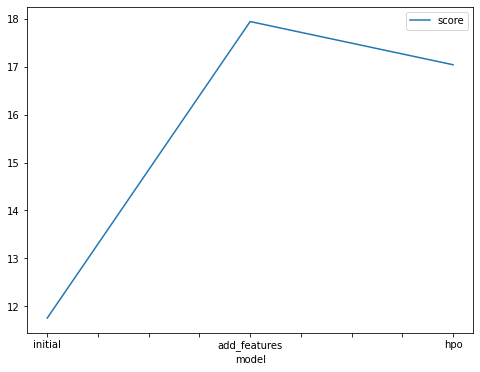

In [5]:
import pandas as pd
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [11.750031, 17.945533, 17.043282]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

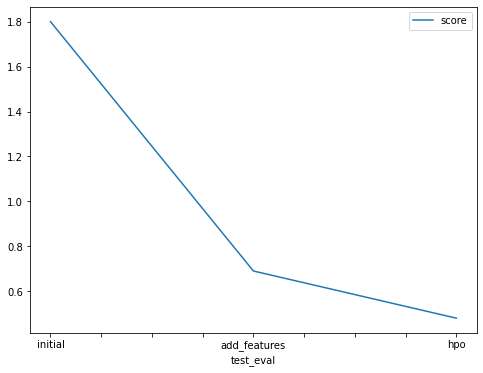

In [6]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.8, 0.69, 0.48]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [7]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "hpo1": ["Default vals", "Default vals", "multimodal"],
    "hpo2": ["Default vals", "Default vals", "Default vals"],
    "hpo3": ["Default vals", "Default vals", "Default vals"],
    "score": [1.8, 0.69, 0.48]
})

,model,hpo1,hpo2,hpo3,score
0,initial,Default vals,Default vals,Default vals,1.80
1,add_features,Default vals,Default vals,Default vals,0.69
2,hpo,multimodal,Default vals,Default vals,0.48
